# 1.사진 로드 확인

In [5]:
import cv2
import cvlib as cv
import matplotlib.pyplot as plt

In [6]:
img = cv2.imread('imgs/01.jpg')

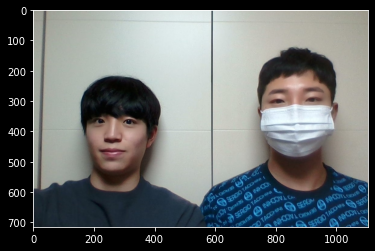

In [7]:
plt.style.use('dark_background')
plt.figure(figsize=(6, 10))
plt.imshow(img[:, :, ::-1])

# 2. Face Detection

In [8]:
# 얼굴 검출
faces, confidences = cv.detect_face(img)

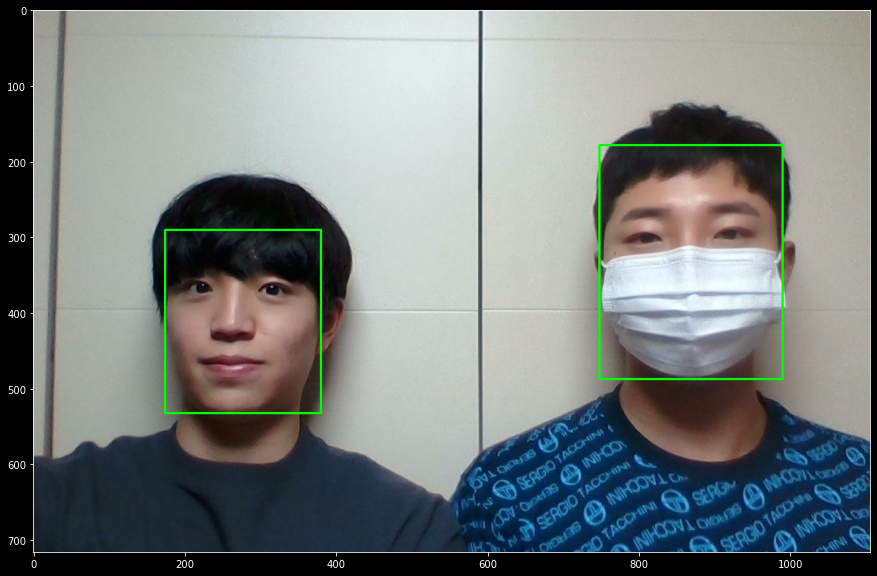

In [9]:
# 검출된 얼굴에 바운딩박스 그리기.
for f in faces:
    (startX,startY) = f[0],f[1]
    (endX,endY) = f[2],f[3]
    
    # 바운딩박스 그리기.
    cv2.rectangle(img, (startX,startY), (endX,endY), (0,255,0), 2)

# 디스플레이 결과
plt.figure(figsize=(15, 10))
plt.imshow(img[:, :, ::-1])
plt.show()

# 3. 마스크 판별기 모델 제작

In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import Sequential
import tensorflow as tf
import numpy as np
import os
 
path_dir1 = './imgs/nomask/'
path_dir2 = './imgs/mask/'


# 해당 경로에 존재하는 파일 목록 가져오기
img_list1 = os.listdir(path_dir1)
img_list2 = os.listdir(path_dir2)
 
img_list1_len = len(img_list1)
img_list2_len = len(img_list2)
 
img_len = img_list1_len + img_list2_len


# 224*224 이미지 전처리
num = 0;
all_img = np.float32(np.zeros((img_len, 224, 224, 3))) 
all_label = np.float64(np.zeros((img_len, 1)))

for img_name in img_list1:
    img_path = path_dir1+img_name
    img = load_img(img_path, target_size=(224, 224))
    
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    all_img[num, :, :, :] = x
    
    # nomask
    all_label[num] = 0
    num = num + 1

for img_name in img_list2:
    img_path = path_dir2+img_name
    img = load_img(img_path, target_size=(224, 224))
    
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    all_img[num, :, :, :] = x
    
    # mask
    all_label[num] = 1
    num = num + 1


# 적절하게 훈련되게 하기 위해 데이터셋 섞기
n_elem = all_label.shape[0]
indices = np.random.choice(n_elem, size=n_elem, replace=False)
 
all_label = all_label[indices]
all_img = all_img[indices]


# 훈련셋 테스트셋 분할
num_train = int(np.round(all_label.shape[0]*0.8))
num_test = int(np.round(all_label.shape[0]*0.2))
 
train_img = all_img[0:num_train, :, :, :]
test_img = all_img[num_train:, :, :, :] 
 
train_label = all_label[0:num_train]
test_label = all_label[num_train:]


# 전이학습 모델 생성
IMG_SHAPE = (224, 224, 3)
 
base_model = ResNet50(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
base_model.trainable = False
base_model.summary()
print("Number of layers in the base model: ", len(base_model.layers))
 
flatten_layer = Flatten()
dense_layer1 = Dense(128, activation='relu')
bn_layer1 = BatchNormalization()
dense_layer2 = Dense(1, activation=tf.nn.sigmoid)
 
model = Sequential([
        base_model,
        flatten_layer,
        dense_layer1,
        bn_layer1,
        dense_layer2,
        ])
 
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
 
model.fit(train_img, train_label, epochs=10, batch_size=16, validation_data = (test_img, test_label))


# 모델 저장 detector.h5
model.save("detector.h5")
 
print("Saved model to disk")  

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

C:\Users\wkdtj\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 36,433,537
Trainable params: 12,845,569
Non-trainable params: 23,587,968
_________________________________________________________________
Epoch 1/10
69/69 [==============================] - 144s 2s/step - loss: 0.0707 - accuracy: 0.9737 - 

C:\Users\wkdtj\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saved model to disk


# 4. 사진속 안면 마스크 유무 판별

In [10]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import cvlib as cv
import cv2

In [11]:
# model = load_model('./models/model.h5')  
model = load_model('./models/detector.h5')
img = cv2.imread('imgs/01.jpg')

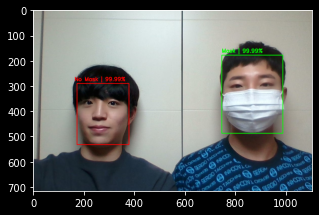

In [12]:
faces, confidences = cv.detect_face(img)

for f in faces:
        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]

        
        if 0 <= startX <= img.shape[1] and 0 <= endX <= img.shape[1] and 0 <= startY <= img.shape[0] and 0 <= endY <= img.shape[0]:
            
            face_region = img[startY:endY, startX:endX]
            
            face_region1 = cv2.resize(face_region, (224, 224), interpolation = cv2.INTER_AREA)
            
            x = img_to_array(face_region1)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            
            prediction = model.predict(x)
            
            if prediction < 0.5: # 마스크 미착용으로 판별되면, 
                cv2.rectangle(img, (startX,startY), (endX,endY), (0,0,255), 2)
                Y = startY - 10 if startY - 10 > 10 else startY + 10
                text = f"No Mask |{(1 - prediction[0][0])*100 : .2f}%"
                cv2.putText(img, text, (startX-10,Y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
                
            else: # 마스크 착용으로 판별되면
                cv2.rectangle(img, (startX,startY), (endX,endY), (0,255,0), 2)
                Y = startY - 10 if startY - 10 > 10 else startY + 10
                text = f"Mask |{(prediction[0][0])*100 : .2f}%"
                cv2.putText(img, text, (startX,Y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

# 디스플레이 결과
plt.figure(figsize=(5, 10))
plt.imshow(img[:, :, ::-1])
plt.show()

# 5. 최종 실시간 안면 마스크 판별기

In [13]:
# 패키지 받아오기
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import winsound as sd
import numpy as np
import cvlib as cv
import cv2


model = load_model('./models/detector.h5')
model.summary()

# open webcam
webcam = cv2.VideoCapture(0)
 

if not webcam.isOpened():
    print("Could not open webcam")
    exit()
    

# 프레임당 카메라 루프
while webcam.isOpened():
    
    # 웹캠 프레임 읽기
    status, frame = webcam.read()
    
    if not status:
        print("프레임을 읽을 수 없습니다.")
        exit()
 
    # 이미지속 얼굴 감지 ( 얼굴 잡고 마스크 검사하기 위해 )
    face, confidence = cv.detect_face(frame)
 
    # 얼굴 감지했을 때 
    for idx, f in enumerate(face):
        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]
        
        if 0 <= startX <= frame.shape[1] and 0 <= endX <= frame.shape[1] and 0 <= startY <= frame.shape[0] and 0 <= endY <= frame.shape[0]:
            
            face_region = frame[startY:endY, startX:endX]
            
            face_region1 = cv2.resize(face_region, (224, 224), interpolation = cv2.INTER_AREA)
            
            x = img_to_array(face_region1)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            
            prediction = model.predict(x)
 
            if prediction < 0.5: # 마스크 미착용으로 판별되면, 
                cv2.rectangle(frame, (startX,startY), (endX,endY), (0,0,255), 2)
                Y = startY - 10 if startY - 10 > 10 else startY + 10
                text = f"No Mask |{(1 - prediction[0][0])*100 : .2f}%"
                cv2.putText(frame, text, (startX-40,Y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
                
                # 마스크 미착용 시 알림
                sd.Beep(2000,500)
                
            else: # 마스크 착용으로 판별되면
                cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)
                Y = startY - 10 if startY - 10 > 10 else startY + 10
                text = f"Mask |{(prediction[0][0])*100 : .2f}%"
                cv2.putText(frame, text, (startX-30,Y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
                
    # 디스플레이 결과 송출 
    cv2.imshow("Face Mask Detection", frame)
 
    # "Q" 웹캠 끄기
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# 리소스 해제
webcam.release()
cv2.destroyAllWindows() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 36,433,537
Trainable params: 12,845,569
Non-trainable params: 23,587,968
_________________________________________________________________


# Real-World Masked Face Dataset 정확도 테스트

In [15]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import os

model = load_model('./models/detector.h5')

In [16]:
path_dir = './imgs/test/'
img_list = os.listdir(path_dir)
test_average = fail = 0

for img_name in img_list:
    img_path=path_dir+img_name
    img = cv2.imread(img_path)
    faces, confidences = cv.detect_face(img)
    
    for f in faces:
           
            (startX, startY) = f[0], f[1]
            (endX, endY) = f[2], f[3]


            if 0 <= startX <= img.shape[1] and 0 <= endX <= img.shape[1] and 0 <= startY <= img.shape[0] and 0 <= endY <= img.shape[0]:

                face_region = img[startY:endY, startX:endX]

                face_region1 = cv2.resize(face_region, (224, 224), interpolation = cv2.INTER_AREA)

                x = img_to_array(face_region1)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)

                prediction = model.predict(x)

                if prediction > 0.5:
                    print(f"{img_name} : {prediction[0][0]*100 : .2f}%")    # 사진마다 정확도
                    if prediction[0][0]*100 > 89: 
                        test_average += prediction[0][0]*100
                    else:
                        fail+=1    # 사진 탐색이 실패할 경우 (89% 이하일 경우 마스크 판별 실패로 처리함)

test_average /= (len(img_list) - fail)
print(f'탐색 Fail 이미지 데이터 개수: {fail}')
print(f'Test 입력데이터 평균 정확도 : {test_average : .2f}%')

test (1).jpg :  100.00%
test (10).jpg :  100.00%
test (100).jpg :  99.97%
test (11).jpg :  100.00%
test (12).jpg :  99.60%
test (12).jpg :  100.00%
test (13).jpg :  99.99%
test (14).jpg :  100.00%
test (15).jpg :  100.00%
test (15).jpg :  99.40%
test (16).jpg :  99.98%
test (17).jpg :  100.00%
test (18).jpg :  99.99%
test (20).jpg :  99.94%
test (21).jpg :  99.99%
test (22).jpg :  99.95%
test (23).jpg :  100.00%
test (24).jpg :  94.11%
test (25).jpg :  99.96%
test (26).jpg :  99.97%
test (27).jpg :  100.00%
test (28).jpg :  100.00%
test (29).jpg :  99.89%
test (3).jpg :  100.00%
test (31).jpg :  99.79%
test (31).jpg :  100.00%
test (31).jpg :  100.00%
test (32).jpg :  100.00%
test (33).jpg :  99.99%
test (35).jpg :  99.96%
test (37).jpg :  100.00%
test (38).jpg :  100.00%
test (39).jpg :  100.00%
test (4).jpg :  96.09%
test (40).jpg :  100.00%
test (41).jpg :  99.49%
test (42).jpg :  99.83%
test (43).jpg :  99.95%
test (44).jpg :  99.99%
test (45).jpg :  99.90%
test (46).jpg :  99.70%
